In [1]:
import pytorch_unet
from batchgenerators.dataloading import DataLoaderBase
import numpy as np
from batchgenerators.augmentations.utils import resize_image_by_padding, random_crop_3D_image_batched, \
    random_crop_2D_image_batched, center_crop_3D_image_batched

# source -> https://github.com/MIC-DKFZ/ACDC2017
class BatchGenerator_2D(DataLoaderBase):
    def __init__(self, data, BATCH_SIZE, PATCH_SIZE=(256, 256), num_batches=None, seed=False):
        self.PATCH_SIZE = PATCH_SIZE
        DataLoaderBase.__init__(self, data, BATCH_SIZE, num_batches=num_batches, seed=seed)

    def generate_train_batch(self):
        data = np.zeros((self.BATCH_SIZE, 1, self.PATCH_SIZE[0], self.PATCH_SIZE[1]), dtype=np.float32)
        seg = np.zeros((self.BATCH_SIZE, 1, self.PATCH_SIZE[0], self.PATCH_SIZE[1]), dtype=np.float32)
        types = np.random.choice(['ed', 'es'], self.BATCH_SIZE, True)
        patients = np.random.choice(list(self._data.keys()), self.BATCH_SIZE, True)
        pathologies = []
        for nb in range(self.BATCH_SIZE):
            shp = self._data[patients[nb]][types[nb]+'_data'].shape
            slice_id = np.random.choice(shp[0])
            tmp_data = resize_image_by_padding(self._data[patients[nb]][types[nb]+'_data'][slice_id], (max(shp[1],
                                                self.PATCH_SIZE[0]), max(shp[2], self.PATCH_SIZE[1])), pad_value=0)
            tmp_seg = resize_image_by_padding(self._data[patients[nb]][types[nb]+'_gt'][slice_id], (max(shp[1],
                                                self.PATCH_SIZE[0]), max(shp[2], self.PATCH_SIZE[1])), pad_value=0)

            # not the most efficient way but whatever...
            tmp = np.zeros((1, 2, tmp_data.shape[0], tmp_data.shape[1]))
            tmp[0, 0] = tmp_data
            tmp[0, 1] = tmp_seg
            tmp = random_crop_2D_image_batched(tmp, self.PATCH_SIZE)
            data[nb, 0] = tmp[0, 0]
            seg[nb, 0] = tmp[0, 1]
            pathologies.append(self._data[patients[nb]]['pathology'])
        return {'data':data, 'seg':seg, 'types':types, 'patient_ids': patients, 'pathologies':pathologies}


In [2]:
from batchgenerators.dataloading import MultiThreadedAugmenter, SingleThreadedAugmenter
from batchgenerators.transforms import Compose, RndTransform
from batchgenerators.transforms import SpatialTransform
from batchgenerators.transforms import MirrorTransform

from batchgenerators.transforms import GammaTransform, ConvertSegToOnehotTransform
from batchgenerators.transforms import RandomCropTransform


# source -> https://github.com/MIC-DKFZ/ACDC2017
def create_data_gen_train(patient_data_train, BATCH_SIZE, PATCH_SIZE, NUM_BATCHES, num_classes,
                                  num_workers=1, num_cached_per_worker=2,
                                  do_elastic_transform=False, alpha=(0., 1300.), sigma=(10., 13.),
                                  do_rotation=False, a_x=(0., 2*np.pi), a_y=(0., 2*np.pi), a_z=(0., 2*np.pi),
                                  do_scale=True, scale_range=(0.75, 1.25), seeds=None):
    if seeds is None:
        seeds = [None]*num_workers
    elif seeds == 'range':
        seeds = range(num_workers)
    else:
        assert len(seeds) == num_workers
    data_gen_train = BatchGenerator_2D(patient_data_train, BATCH_SIZE, num_batches=NUM_BATCHES, seed=False,
                                       PATCH_SIZE=PATCH_SIZE)

    tr_transforms = []
    tr_transforms.append(MirrorTransform((0, 1)))
    tr_transforms.append(RndTransform(SpatialTransform(PATCH_SIZE, list(np.array(PATCH_SIZE)//2),
                                                       do_elastic_transform, alpha,
                                                       sigma,
                                                       do_rotation, a_x, a_y,
                                                       a_z,
                                                       do_scale, scale_range, 'constant', 0, 3, 'constant',
                                                       0, 0,
                                                       random_crop=False), prob=0.67,
                                      alternative_transform=RandomCropTransform(PATCH_SIZE)))
    tr_transforms.append(ConvertSegToOnehotTransform(range(num_classes), seg_channel=0, output_key='seg_onehot'))

    #tr_composed = Compose(tr_transforms)
    tr_composed = Compose([ConvertSegToOnehotTransform(range(num_classes), seg_channel=0, output_key='seg_onehot')])

#     tr_mt_gen = MultiThreadedAugmenter(data_gen_train, tr_composed, num_workers, num_cached_per_worker, seeds)
#     tr_mt_gen.restart()
    tr_mt_gen = SingleThreadedAugmenter(data_gen_train, tr_composed) 
    return tr_mt_gen

In [3]:
cf = {
    'BATCH_SIZE': 4,
    'INPUT_PATCH_SIZE': (348, 348), # calculated using notebook: Calculate-U-Net Size
    'num_classes': 4,
    'EXPERIMENT_NAME': 'Test-Implementation',
    'results_dir': './results-experiment',
    'n_epochs': 5,
    'lr_decay': np.float32(0.985),
    'base_lr': np.float32(0.0005),
    'n_batches_per_epoch': 10,
    'n_test_batches': 10,
    'n_feedbacks_per_epoch': 10,
    'num_workers': 6,
    'workers_seeds': [123, 1234, 12345, 123456, 1234567, 12345678],
    'weight_decay': 1e-5,
    'n_input_channels': 1
}

In [4]:
import os

BATCH_SIZE = cf['BATCH_SIZE']
INPUT_PATCH_SIZE = cf['INPUT_PATCH_SIZE']
num_classes = cf['num_classes']
EXPERIMENT_NAME = cf['EXPERIMENT_NAME']
results_dir = cf['results_dir']
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
n_epochs = cf['n_epochs']
lr_decay = cf['lr_decay']
base_lr = cf['base_lr']
n_batches_per_epoch = cf['n_batches_per_epoch']
n_test_batches = cf['n_test_batches']
n_feedbacks_per_epoch = cf['n_feedbacks_per_epoch']
num_workers = cf['num_workers']
workers_seeds = cf['workers_seeds']

In [5]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

# source -> https://github.com/usuyama/pytorch-unet
def calc_loss(pred, target, metrics, bce_weight=0.5):
    #print(target)
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

# source -> https://github.com/usuyama/pytorch-unet
def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    


# adapted from -> https://github.com/usuyama/pytorch-unet    
def train_model(model, optimizer, scheduler, dataloaders, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for i, data_dict in enumerate(dataloaders[phase]):
                
                inputs = torch.from_numpy(data_dict['data']).to(device)
                types = data_dict['types']
                patient_ids = data_dict['patient_ids']
                pathologies = data_dict['pathologies']
                seg_onehot = data_dict['seg_onehot']
                labels = torch.from_numpy(data_dict['seg_onehot']).to(device) # we need an output encoded into 4 layers          

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = labels[:,:,92:INPUT_PATCH_SIZE[0]-92,92:INPUT_PATCH_SIZE[1]-92]
                    loss = calc_loss(outputs, labels, metrics)
                    if i % 250 == 0:
                        print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            if phase == 'train':
                train_history.append(epoch_loss)
            elif phase == 'val':
                val_history.append(epoch_loss)            

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_history, val_history

In [6]:
from sklearn.model_selection import KFold

# source -> https://github.com/MIC-DKFZ/ACDC2017
def get_split(fold, seed=12345):
    # this is seeded, will be identical each time
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    all_keys = np.arange(1, 101)
    splits = kf.split(all_keys)
    for i, (train_idx, test_idx) in enumerate(splits):
        train_keys = all_keys[train_idx]
        test_keys = all_keys[test_idx]
        if i == fold:
            break
    return train_keys, test_keys

In [7]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from preprocessing import load_dataset
import unet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = cf['num_classes']

opts = {'duke_unet_opts':{"n_input_channels":cf['n_input_channels'],"n_classes":cf['num_classes']}}

model = unet.Unet(opts).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)


fold = 0
train_keys, test_keys = get_split(fold)
train_data = load_dataset(train_keys)

data = load_dataset()
nb_entities = len(data)
types = [x for x in data[1].keys() if 'data' in x.split('_')]
nb_samples = []
for typ in types:
    nb_samples.append([np.shape(data[x][typ])[0] for x in range(1,nb_entities+1)])
max_samples = max(nb_samples[0]+nb_samples[1])
min_samples = min(nb_samples[0]+nb_samples[1])
avg_samples = np.ceil(np.mean(nb_samples[0]+nb_samples[1]))
all_samples_without_transformation = nb_entities * len(types) * avg_samples
ALL_SAMPLES = all_samples_without_transformation
NUM_BATCHES = np.ceil(ALL_SAMPLES/BATCH_SIZE)
NUM_BATCHES = 100

val_data = load_dataset(test_keys)

data_gen_validation = BatchGenerator_2D(val_data, BATCH_SIZE, num_batches=NUM_BATCHES, seed=False,
                                        PATCH_SIZE=INPUT_PATCH_SIZE)
data_gen_validation = MultiThreadedAugmenter(data_gen_validation,
                                             ConvertSegToOnehotTransform(range(num_classes), 0, "seg_onehot"),
                                             1, 2, [0])
data_gen_training = create_data_gen_train(train_data, cf['BATCH_SIZE'], cf['INPUT_PATCH_SIZE'], NUM_BATCHES, cf['num_classes'])
dataloaders = {'train': data_gen_training, 'val': data_gen_validation}
model, train_history, val_history = train_model(model, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=cf['n_epochs'])


cuda:0


/home/adri/Studies/PhD_UCD/notebooks/batchgenerators/dataloading/data_loader.py:53: DeprecationWarning: This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!
  warn("This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!", DeprecationWarning)
/home/adri/Studies/PhD_UCD/notebooks/batchgenerators/dataloading/data_loader.py:58: UserWarning: We currently strongly discourage using num_batches != None! That does not seem to work properly
  warn("We currently strongly discourage using num_batches != None! That does not seem to work properly")
/home/adri/Studies/PhD_UCD/notebooks/batchgenerators/dataloading/data_loader.py:53: DeprecationWarning: This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!
  warn("This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!", DeprecationWarning)
/home/adri/Studies/PhD_UCD/notebooks/batchgenerators/dataloading/data_loader.py:58: UserWarning: 

Epoch 0/4
----------
LR 0.0001
tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)
train: bce: 0.382130, dice: 0.756698, loss: 0.569414
tensor(0.4667, device='cuda:0')
val: bce: 0.181692, dice: 0.705315, loss: 0.443503
saving best model
1m 4s
Epoch 1/4
----------
LR 0.0001
tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)
train: bce: 0.165456, dice: 0.682150, loss: 0.423803
tensor(0.4033, device='cuda:0')
val: bce: 0.161305, dice: 0.660609, loss: 0.410957
saving best model
1m 39s
Epoch 2/4
----------
LR 0.0001
tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)
train: bce: 0.161996, dice: 0.628321, loss: 0.395158
tensor(0.3846, device='cuda:0')
val: bce: 0.143687, dice: 0.583600, loss: 0.363643
saving best model
1m 41s
Epoch 3/4
----------
LR 0.0001
tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)
train: bce: 0.117665, dice: 0.511735, loss: 0.314700
tensor(0.2980, device='cuda:0')
val: bce: 0.126083, dice: 0.482696, loss: 0.304389
saving best model
1m 45s
Epoch 4/4

In [8]:
from datetime import datetime
now = datetime.now()

torch.save(model, './entire_model_' + now.strftime("%Y-%m-%d_%H-%M-%S") + '.pth')

#### Do some inference and save results

In [12]:
data_dict = next(data_gen_training)
inputs = torch.from_numpy(data_dict['data']).to(device)
outputs = model(inputs)
outputs.cpu().detach().numpy().to_filename('out.nii.gz')

RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 1.96 GiB total capacity; 897.73 MiB already allocated; 25.56 MiB free; 32.27 MiB cached)

#### Collect activations

In [18]:
def activations(model, loader, layer_fun=None, n_sample=10):
    """
    Return Activations

    :param model: An nn.Module object whose activations we want to inspect.
    :param loader: A generator whose next() iterator returns (x, y).
    :param layer_fun: A function that returns a tensor of features, when
      applied to a model and input x.
    :param n_sample: The number of images from the loader to compute
      activations for.
    :returns summary: A list of dictionaries, each giving the image patch,
      feature activations for the first n_sample patches in
      the loader.

    Example
    -------
    >>> loader = patch_gen_train()
    >>> model = UNet(params["model_opts"])
    >>> model.load_state_dict(
          torch.load(model_path)
        )
    >>>
    >>> summary = activations(model, loader)
    """
    if not layer_fun:
        layer_fun = lambda model, x: model.pre_pred(x)

    summary = []
    for i, D in enumerate(loader):
        print("batch {}".format(i))
        if i > n_sample:
            break

        # each element of the batch
        x = torch.from_numpy(D['data']).to(device)
        types = D['types']
        patient_ids = D['patient_ids']
        pathologies = D['pathologies']
        seg_onehot = D['seg_onehot']
        y = torch.from_numpy(D['seg_onehot']).to(device) # we need an output encoded into 4 layers          
        
        h = layer_fun(model, x)
        for j, _ in enumerate(x):
            summary.append({
                "x": x[j].detach().cpu().numpy(),
                "h": h[j].detach().cpu().numpy(),
            })

    return summary


def ft_fun(model, x):
    """
    Activations to write for the U-net
    """
    x, conv1_out, conv1_dim = model.down_1(x)
    x, conv2_out, conv2_dim = model.down_2(x)
    x, conv3_out, conv3_dim = model.down_3(x)
    x, conv4_out, conv4_dim = model.down_4(x)

    # norms for each feature map at the encoder layer
    x = model.conv5_block(x)
    return torch.sum(x ** 2, dim=(2, 3)) ** (0.5)

def reshape_activations(summary):
    """
    Matrix-ify the output of activations()

    :param summary: The output of the activations function. This is a list of
      dictionaries describing each patch.
    :return: A tuple with the following components,
      H: A numpy array whose rows correspond to patches and whose values are
      activations.

    Example
    -------
    >>> summary = activations(model, loader)
    >>> H = reshape_activations(summary)
    >>>
    >>> np.savetxt(os.path.join(params["save_dir"], "H.csv"), H, delim=",")
    """
    N = len(summary)
    K = len(summary[0]["h"])

    H = np.zeros((N, K))


    for i in range(N):
        H[i] = summary[i]["h"]

    return H

In [26]:
def save_summary(model, loader, layer_fun, out_path, **kwargs):
    summary = activations(model, loader, layer_fun, n_sample=10)
    H = reshape_activations(summary)
    np.savetxt("{}-H.csv".format(out_path), H, delimiter=",")

# save activations to file
save_summary(
    model,
    data_gen_training,
    ft_fun,
    "./results_experiment/",
    n_sample=20
)

batch 0


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 916.57 MiB already allocated; 25.56 MiB free; 13.43 MiB cached)

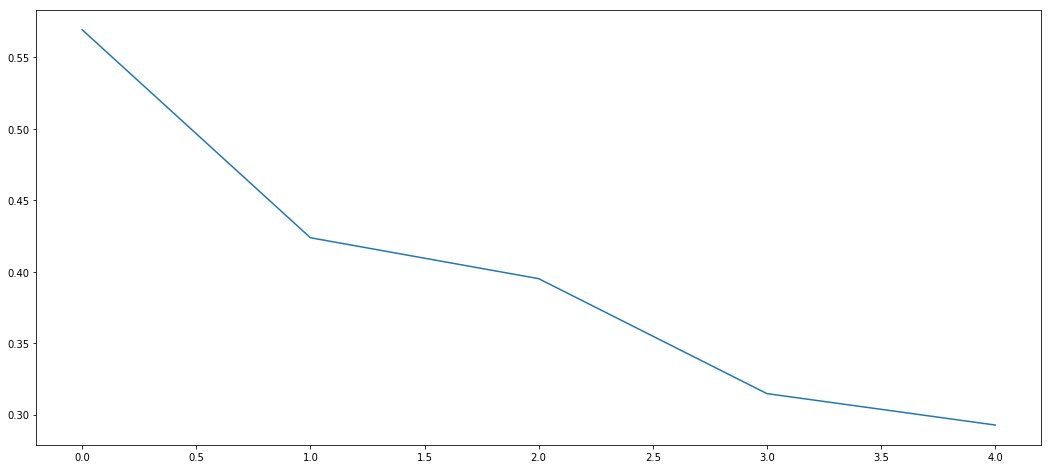

(5,)

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(train_history)
plt.plot(val_history)
plt.show()

### Estimate time that it will take to train the model

- How much data samples do we have?
- How much time does it take to process one batch?
- How many epochs does it suppose to run?
- How much time does it take to process one epoch?

#### How much data samples do we have?

In [ ]:
data = load_dataset()

In [ ]:
nb_entities = len(data)
types = [x for x in data[1].keys() if 'data' in x.split('_')]
nb_samples = []
for typ in types:
    nb_samples.append([np.shape(data[x][typ])[0] for x in range(1,nb_entities+1)])
max_samples = max(nb_samples[0]+nb_samples[1])
min_samples = min(nb_samples[0]+nb_samples[1])
avg_samples = np.ceil(np.mean(nb_samples[0]+nb_samples[1]))
all_samples_without_transformation = nb_entities * len(types) * avg_samples
ALL_SAMPLES = all_samples_without_transformation
NUM_BATCHES = np.ceil(ALL_SAMPLES/BATCH_SIZE)

In [ ]:
print("There are {} patients in the dataset.".format(nb_entities))
print("There are {} types of data per patient.".format(len(types)))
for typ in types:
    print("There are {} samples of type: {}".format(np.shape(data[1][typ])[0], typ))
print('There are around {} number of samples without transformation'.format(all_samples_without_transformation))

#### How much time does it take to process one batch?

#### How many epochs does it suppose to run?

#### How much time does it take to process one epoch?

##### Without transformations

In [27]:
# with batch size = 1
times = ['9m 45s', '11m 28s', '11m 28s', '11m 32s', '11m 36s']
minutes = [int(x.split('m')[0])*60 for x in times]
seconds = [int(x.split(' ')[1].split('s')[0]) for x in times]
times_sec = []
for i in range(len(minutes)):
    times_sec.append((minutes[i] + seconds[i])/60)
mean = np.mean(times_sec)
print("{0}m {1}s | On avarage it takes {0} minutes and {1} seconds to train one epoch.".format(int(mean),np.ceil((mean - int(mean))*60)))

11m 10.0s | On avarage it takes 11 minutes and 10.0 seconds to train one epoch.


In [ ]:
print("It takes 9m 45s to process one epoch of batch size with 1 sample.")

##### With the following transformations:

--------------------------------------

##### Decisions to be made:

- What transformations to use?
- How big the batch should be?
- For how many epochs it shoud train for?
- How many batches should be in one epoch?

##### TODO:

- why the heck, the images are rotated and scaled in the batches even with transforms off? - investigate
- correct collected intermediate metrics +
- collect activations from the ordered batch generator <br> to make it more meaningful to analyze
- single patient data input +
- assess model performance +
- extract training parameters into a separate file +
- collect training history +
- save training history to the file +
- train the network +
- collect activations from the bottleneck layer +
- collect adequate patches +
- plot results +
- submission file for ACDC17 format: patientXXX_ED.nii.gz and patientXXX_ES.nii.gz, https://acdc.creatis.insa-lyon.fr/#phase/5846c3ab6a3c7735e84b67f2/submit 

#### Links:

- https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html
- https://acdc.creatis.insa-lyon.fr/#phase/5846c3ab6a3c7735e84b67f2/submit
- https://www.creatis.insa-lyon.fr/Challenge/acdc/evaluationSegmentation.html
- https://www.creatis.insa-lyon.fr/Challenge/acdc/code/metrics_acdc.py

From Isensee et al.:
"The 3D model was trained for 300 epochs in a 5-fold cross validation using the
ADAM solver and a pixel-wise categorical cross-entropy loss. The initial learning
rate of 5 · 10−4 was decayed by 0.98 per epoch, where an epoch was defined as
100 batches, each comprising four training examples. Training examples were
generated as random crops of size 224 × 224 × 10 voxels taken from a randomly
chosen training patient and phase instance (ED/ES)."
